In [ ]:
import numpy as np
import pandas as pd
from fastai.vision.all import *
from PIL import Image
from albumentations import *
import matplotlib.pyplot as plt

import os
from pathlib import Path
import glob

import cv2 as cv

In [ ]:
from fastai.data.all import *

## Begin Model
- Using all for training, not enough for valid
- Currently dealing with error on image sizes not being the same <- will need to revisit preprocessing

In [ ]:
# Set path to images and annotations
path_im ='/content/drive/MyDrive/DL_Hip_FAI_Measurements/Femoral_Head_Resize'
path_lbl = '/content/drive/MyDrive/DL_Hip_FAI_Measurements/Femoral_Head_Annot_Resize'

In [ ]:
# ID Training files and Labels
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

In [ ]:
# Map function for image to segmentation (revisit, may want to have different name for segmentations)
get_y_fn = lambda x: path_lbl+f'/{x.stem}'+'_annot.png'

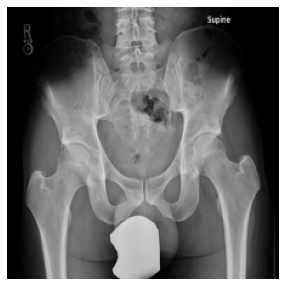

In [ ]:
# Observe Samples
img_fn = fnames[1]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

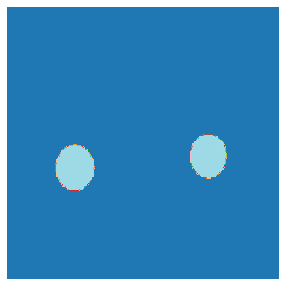

In [ ]:
img_f = fnames[1]
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
# Semgmentation IDs (Might want to revisit and just use 0 and 1)
codes = np.array(['None', 'Femoral Head'])

In [ ]:
src_size = np.array(mask.shape[1:])
size = src_size//2

In [ ]:
# Create Data Loader
dls = SegmentationDataLoaders.from_label_func(path_im, bs=8, 
                                                    fnames = fnames,
                                                    label_func = get_y_fn, 
                                                    codes = codes,
                                              # item_tfms=Resize(1024),
                                              #  batch_tfms=[*aug_transforms(min_scale=0.5, size=224)]
                                              )

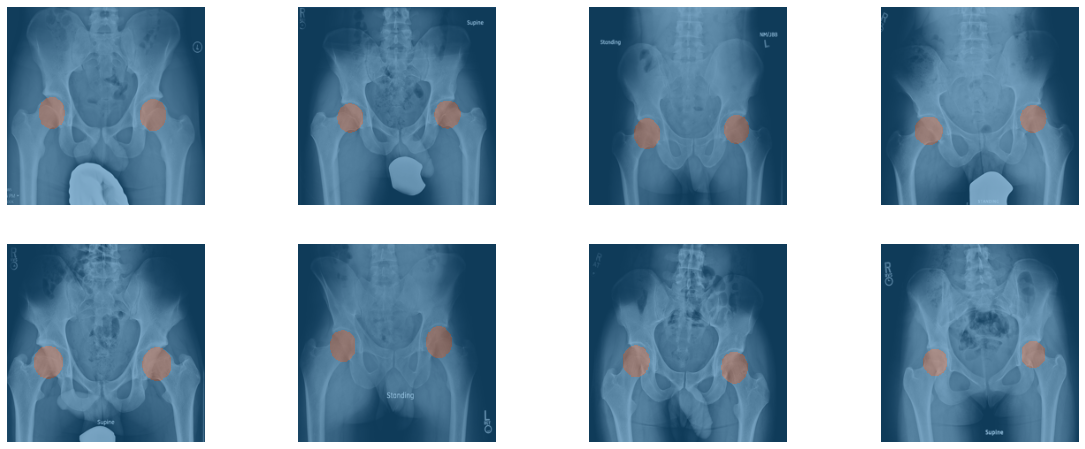

In [ ]:
# Look at random batch of images (Looks good)
dls.show_batch(max_n=8,figsize=(20,8))

In [ ]:
# Confirm splits (May want to revisit how to limit validation size)
len(dls.train_ds), len(dls.valid_ds)

(60, 15)

In [ ]:
# Download U-Net Architecture
learn = unet_learner(dls, resnet34,metrics=[Dice()]).to_fp16()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=5.248074739938602e-05)

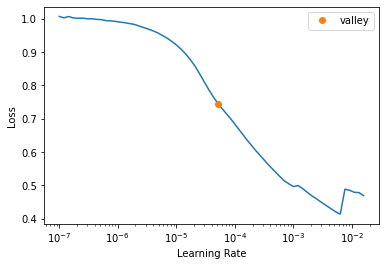

In [ ]:
# Investigate best Learning rates
learn.lr_find()

In [ ]:
# Train model 20 cycles
cb1 = SaveModelCallback(monitor='dice',fname='/content/drive/MyDrive/DL_Hip_FAI_Measurements/Tested_Models/best_model_pass1',comp=np.greater) # Callbacks
cb2 = ReduceLROnPlateau(monitor='dice', patience=1,factor=0.2)
learn.fit_one_cycle(20, 1e-3,cbs = [cb1,cb2])

epoch,train_loss,valid_loss,dice,time
0,0.575393,0.482663,0.000000,00:08
1,0.360885,0.146650,0.000000,00:01
2,0.270907,0.123030,0.000000,00:01
3,0.214075,0.057071,0.000000,00:01
4,0.169615,0.047316,0.557030,00:01
5,0.137786,0.041996,0.721552,00:01
6,0.113326,0.016928,0.901080,00:01
7,0.094094,0.012921,0.916732,00:01
8,0.078478,0.011991,0.927345,00:01
9,0.066121,0.012864,0.922052,00:01


Better model found at epoch 0 with dice value: 0.0.
Better model found at epoch 4 with dice value: 0.5570298090081514.
Better model found at epoch 5 with dice value: 0.7215516787013124.
Better model found at epoch 6 with dice value: 0.9010795329367702.
Better model found at epoch 7 with dice value: 0.9167318056526926.
Better model found at epoch 8 with dice value: 0.9273448906985831.
Better model found at epoch 10 with dice value: 0.9334904866139081.
Better model found at epoch 13 with dice value: 0.9358744954433856.
Better model found at epoch 15 with dice value: 0.9371172578192429.


## Inference

In [ ]:
learn.load('/content/drive/MyDrive/DL_Hip_FAI_Measurements/Tested_Models/best_model_pass1')

/usr/local/lib/python3.8/dist-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


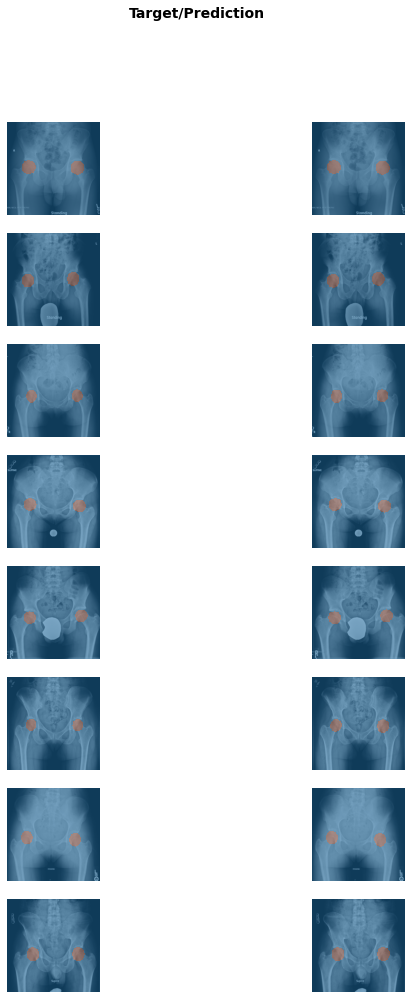

In [ ]:
learn.show_results(max_n = 8, figsize = (10,16) )

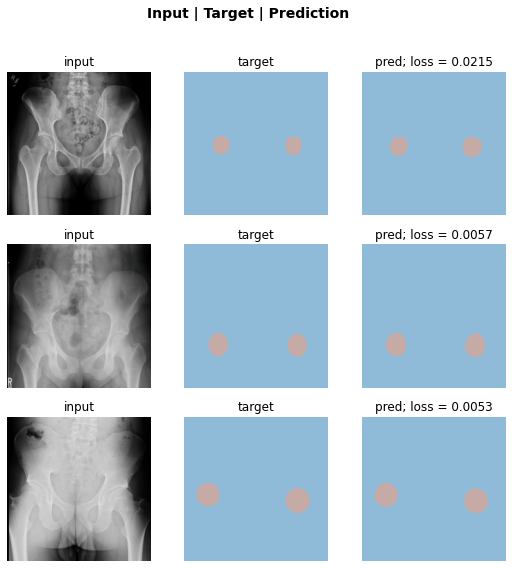

In [ ]:
# What was our worst examples (not bad at all)
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

### Predicting Single Use Case

In [ ]:
# Predicting on single use case via model
test_img = Image.open('/content/drive/MyDrive/DL_Hip_FAI_Measurements/Femoral_head_test/901_AP_PELVIS.png')
test_img = test_img.resize((224,224)) # Resize to model expectations
test_img.save('/content/drive/MyDrive/DL_Hip_FAI_Measurements/Femoral_head_test/901_AP_PELVIS.png')

In [ ]:
preds = learn.predict('/content/drive/MyDrive/DL_Hip_FAI_Measurements/Femoral_head_test/901_AP_PELVIS.png')

In [ ]:
preds[0]

TensorMask([[0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            ...,
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0]])

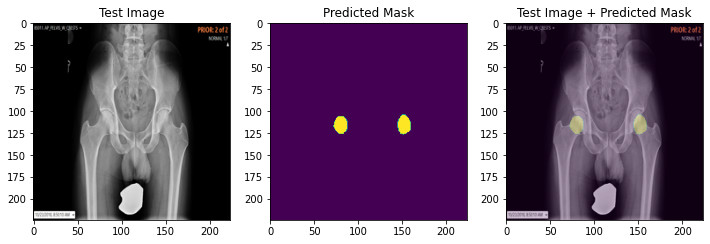

In [ ]:
# Artificially looks really good since it could be a training sample
fig, ax = plt.subplots(1,3, figsize = (12,6))
ax[0].imshow(test_img)
ax[0].set_title('Test Image')
ax[1].imshow(preds[0])
ax[1].set_title('Predicted Mask');
ax[2].imshow(test_img)
ax[2].imshow(preds[0], alpha = 0.25)
ax[2].set_title('Test Image + Predicted Mask');
fig.show();

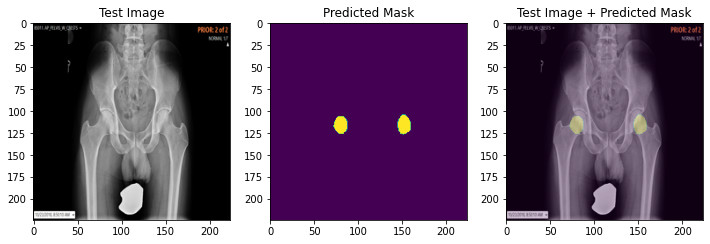

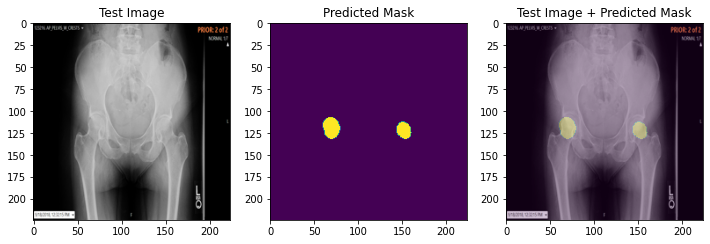

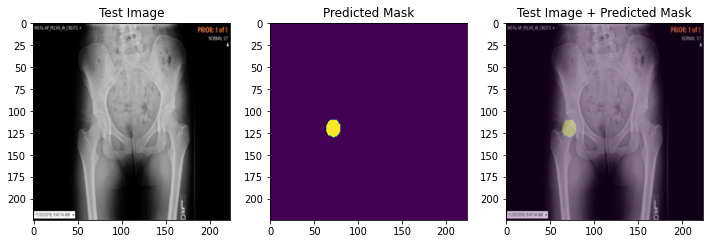

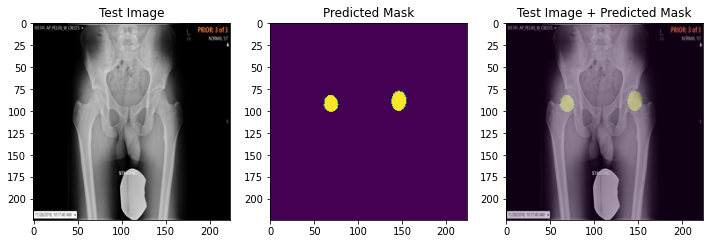

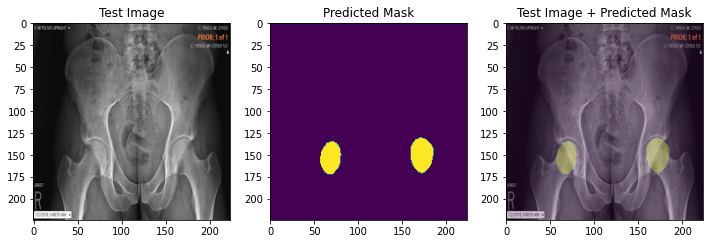

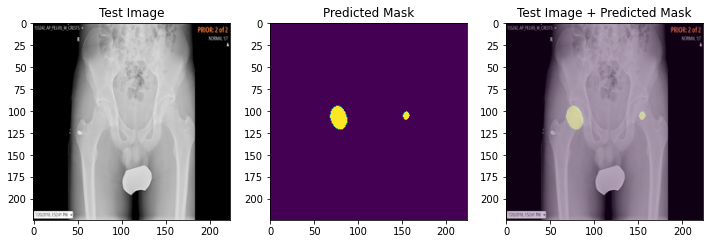

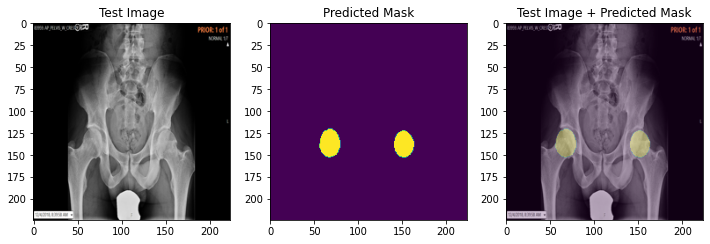

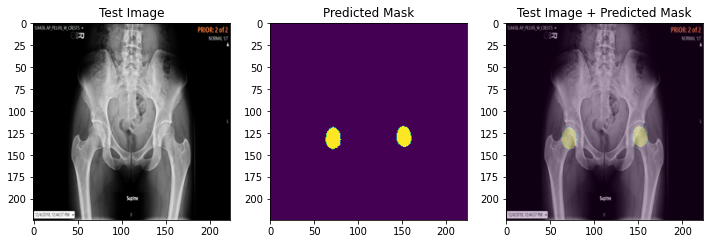

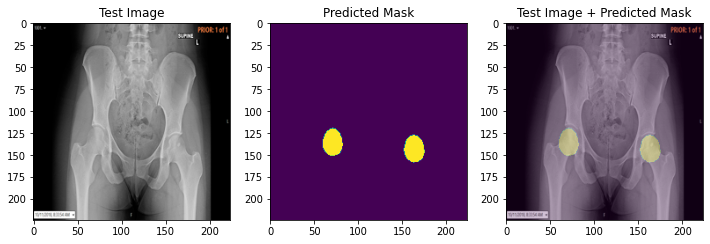

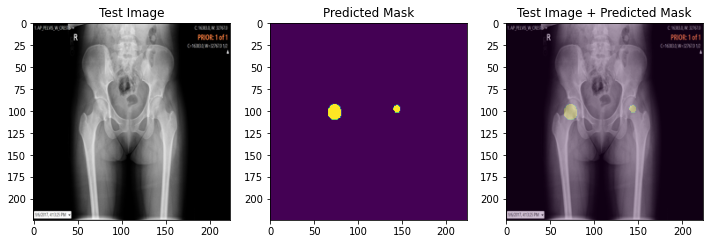

In [ ]:
# Loop Through
test_files = glob.glob('/content/drive/MyDrive/DL_Hip_FAI_Measurements/Femoral_head_test/*')
for i in test_files:
  test_img = Image.open(i)
  test_img = test_img.resize((224,224)) # Resize to model expectations
  test_img.save(i)
  preds = learn.predict(i)
  fig, ax = plt.subplots(1,3, figsize = (12,6))
  ax[0].imshow(test_img)
  ax[0].set_title('Test Image')
  ax[1].imshow(preds[0])
  ax[1].set_title('Predicted Mask');
  ax[2].imshow(test_img)
  ax[2].imshow(preds[0], alpha = 0.25)
  ax[2].set_title('Test Image + Predicted Mask');
  fig.show();

## Post-Analysis Getting Circle and Mid-Line

In [ ]:
# Convert Mask to array
pred_mask = preds[0].numpy().astype(np.float32)#*255
# pred_mask = Image.fromarray(pred_mask)

In [ ]:
# circles = cv.HoughCircles(pred_mask,cv.HOUGH_GRADIENT,50,20,
#                             param1=100,param2=30,minRadius=10,maxRadius=100)
# cimg = cv.imread('/content/drive/MyDrive/DL_Hip_FAI_Measurements/Femoral_Head_Resize/10_AP_PELVIS.png')
# for i in circles[0,:]:
#     # draw the outer circle
#     cv.circle(cimg,(int(i[0]),int(i[1])),int(i[2]),(0,255,0),2)
#     # draw the center of the circle
#     # cv.circle(cimg,(int(i[0]),int(i[1])),2,(0,0,255),3)
# from google.colab.patches import cv_imshow
# cv_imshow(cimg)


In [ ]:
from sklearn.cluster import KMeans

df = pd.DataFrame(pred_mask).stack().rename_axis(['y', 'x']).reset_index(name='val')
means = KMeans(n_clusters=2).fit(df.values)

center1 = means.cluster_centers_[0][:-1]
center2 = means.cluster_centers_[1][:-1]

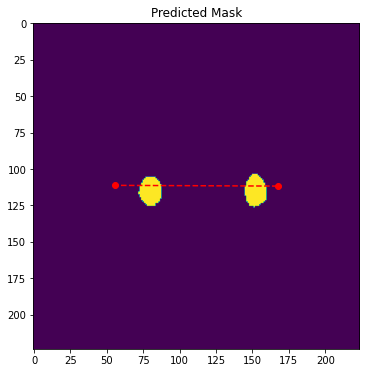

In [ ]:
fig, ax = plt.subplots( figsize = (12,6))
ax.imshow(preds[0])
ax.set_title('Predicted Mask');
ax.plot([center1[0], center2[0]], [center1[1], center2[1]], '--ro')
# ax.plot(*center1, 'ro')
# ax.plot(*center2, 'ro')
fig.show();

In [ ]:
Image.fromarray(pred_mask).convert('RGB').save('test.png')

In [ ]:
# Load the image and convert it to grayscale:
image = cv.imread("/content/test.png")
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply cv.threshold() to get a binary image
ret, thresh = cv.threshold(gray_image, 0, 255, cv.THRESH_BINARY)

# Find contours:
im, contours = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

# Draw contours:
# cv.drawContours(image, contours, 0, (0, 255, 0), 2)

# Calculate image moments of the detected contour
M = cv.moments(np.int32(contours[0]))

# Print center (debugging):
print("center X : '{}'".format(round(M['m10'] / M['m00'])))
print("center Y : '{}'".format(round(M['m01'] / M['m00'])))

error: ignored

In [ ]:
im

array([[[ 1, -1, -1, -1],
        [-1,  0, -1, -1]]], dtype=int32)

In [ ]:
thresh

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

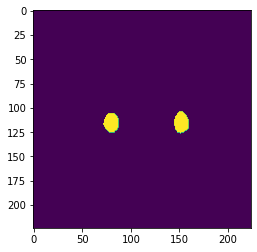

In [ ]:
plt.imshow(thresh)

In [ ]:
import seaborn as sns 

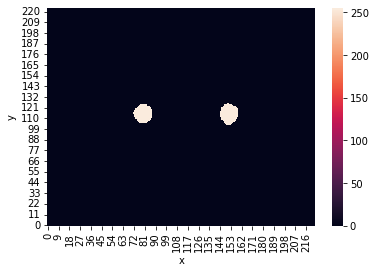

In [ ]:
table = df.pivot('y', 'x', 'val')
ax = sns.heatmap(table)
ax.invert_yaxis()
plt.show()